In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import math
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from scipy.stats import pearsonr

file_vwnd = '../dataset/V_WIND.nc'
file_uwnd = '../dataset/U_WIND.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)
# vwnd(time, level, lat, lon) current shape = (904, 17, 73, 144)
vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']


# cor_num = pd.read_excel(io = r'./dataset/SI0922.xlsx')
# coordinate = cor_num['5AV.SI'].tolist()


In [5]:
# 求level在850处的涡度
# |delta v / |delta x - |delta u / |delta y
# 因为纬度lat有地球偏差 x = x * cos(lat) * 111
# 每一年计算一个涡度，每个点在时间序列上有40个涡度值
# 对每个点进行相关计算
vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]

In [6]:
# 计算相邻两点之间的绝对距离 lat纬度 lon经度
lat = vlat[:].data
Y_derivative = abs((lat[2]-lat[0])*111)
lon = vlon[:].data
X_derivative = (lon[2]-lon[0])*111
print(X_derivative, Y_derivative)

# 计算涡度需要上面那个点 因此上下都多一行
# vwind_mid = vwnd[:1,2:3,18:55,:].data[0][0] 
vwind_mid = vwnd[:1,2:3,17:56,:].data[0][0] 
uwind_mid = uwnd[:1,2:3,17:56,:].data[0][0] 

555.0 555.0


In [12]:
for i in range(lat.shape[0]):
    if lat[i] == 45.0 or lat[i] == -45.0:
        print(i)

18
54


In [7]:
def num_month_12toNext4(a):
    num_months = (a - 1948) * 12 
    start = num_months - 1
    end = start + 12
    return start, end
#     if start <= 0:
#         return print("Out Break!")
#     else:
#         return start, end

def vorticity_year(start, end):
    # start开始月份 end结束月分，num_month
    num_month = int(end-start)
#     print(start, end, num_month)
    tmp_vorticity_year = np.zeros((37,144), dtype=float, order='C')
    for i in range(start, end):
        vwind_mid_tmp = vwnd[i:i+1,2:3,17:56,:].data[0][0]
        X_vorticity_tmp = X_vorticity(vwind_mid_tmp)  
        uwind_mid_tmp = uwnd[i:i+1,2:3,17:56,:].data[0][0] 
        Y_vorticity_tmp = Y_vorticity(uwind_mid_tmp)
        vorticity_tmp = X_vorticity_tmp - Y_vorticity_tmp
        tmp_vorticity_year += vorticity_tmp
    vorticity_mean = tmp_vorticity_year / num_month
    return vorticity_mean

def X_vorticity(vwind_mid):
    # 计算每个点的涡度 X_vorticity = dv / dx
    X_vorticity = np.zeros((37,144), dtype=float, order='C')
    # 从第1行计算到倒数第二行的涡度
    for row in range(1, vwind_mid.shape[0]-1):
        # 在row行的风数值
        vwind_lat = vwind_mid[row]
        # row行的lat纬度值
#         row_lat = lat[row+17]
    #     print(row, row+17)
        X_dis = X_derivative*math.cos(math.radians(lat[row-1]))
        for i in range(len(vwind_lat)):
            if i<=len(vwind_lat)-2:
                X_vorticity[row-1][i] = (vwind_lat[i+1]-vwind_lat[i-1])/X_dis
            elif i == len(vwind_lat)-1:
                X_vorticity[row-1][i] = (vwind_lat[len(vwind_lat)-i]-vwind_lat[i-1])/X_dis
    return X_vorticity

def Y_vorticity(uwind_lat):
    # 计算 Y_vorticity = du/dy
    # 对于第一行的涡度，用第三行减去第一行，除以距离
    Y_vorticity = np.zeros((37,144), dtype=float, order='C')
    for i in range(1, 38):
        Y_vorticity[i-1] = (uwind_lat[i]-uwind_lat[i-2])/Y_derivative
    return Y_vorticity

def vorticity_mean(startYear, endYear):
    num_year = endYear-startYear
    vorticity_mean = np.zeros((num_year,37,144), dtype=float, order='C')
    for year in range(startYear, endYear):
        start, end = num_month_12toNext4(year)
        vort_tmp = vorticity_year(start, end)
#         print(vort_tmp)
        index = year - startYear
#         print(index)
        vorticity_mean[index:index+1,:,:] = vort_tmp
    return vorticity_mean



In [8]:
vor_first = vorticity_mean(1980, 2000)
vor_second = vorticity_mean(2000, 2022)

In [9]:
def point_vor_mean(vor, i, j):
    """
    i: 纬度0-37  j: 经度0-144
    """
    sum_vor = 0
    for i in vor[:,i:i+1,j:j+1].tolist():
        tmp = i[0][0]
        sum_vor += tmp
    mean_vor = sum_vor / vor.shape[0]
    return mean_vor

def mean_rv_phase(vor):
    mean_rv = np.zeros((37,144), dtype=float, order='C')
    for row_lat in range(0,37):
        for col_lon in range(0,144):
            mean_tmp = point_vor_mean(vor, row_lat, col_lon)
            mean_rv[row_lat,col_lon] = mean_tmp
    return mean_rv



In [10]:
mean_rv_first = mean_rv_phase(vor_first)
mean_rv_second = mean_rv_phase(vor_second)

diff = (mean_rv_second - mean_rv_first) 

print((diff.max(), diff.min()))

(47664698230705.65, -82231343285162.66)


In [11]:
diff.shape

(37, 144)

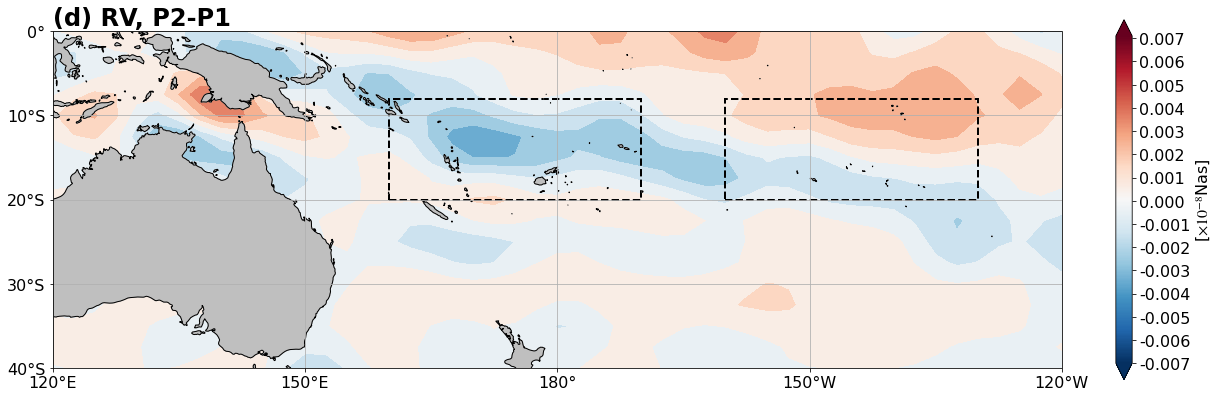

In [13]:
from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from matplotlib import rcParams
from matplotlib import patches

longitude, latitude = dataset_vwnd.variables['lon'],dataset_vwnd.variables['lat']


# 设置字体
config = {
    "font.family": 'Times New Roman',
    "font.size": 16,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 0.0071
MIN = -0.007 
INTER = 0.001
# 设置经纬度
lon = vlon[:].data
lat = vlat[19:56].data
# # 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
# print(diff_pacific_contre.max(), diff_pacific_contre.min())


fig = plt.figure(figsize=(15,5))


proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(d) RV, P2-P1',loc='left',fontsize =24, fontweight='bold')
# fig_ax1.contourf(lon, lat, diff, 
#                 levels=bins, 
# #                 color=['blue','red','yellow','black'],
# #                 hatches='///',
#                 transform=cartopy.crs.PlateCarree(),
#                cmap=plt.cm.RdBu_r)
cont = fig_ax1.contourf(lon, lat, diff, 
                 levels=np.arange(MIN, MAX, INTER),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
# fig_ax1.contourf(lon, lat, diff,levels=[0,0.05,1], zorder=1, hatches=['....',None],colors="none", transform=ccrs.PlateCarree())

# black_quarter = patches.Rectangle((146,-24),71,19,linestyle = 'dashed', 
#                                   lw=4, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
# fig_ax1.add_patch(black_quarter)

black_quarter_b1 = patches.Rectangle((160,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
black_quarter_b2 = patches.Rectangle((200,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
fig_ax1.add_patch(black_quarter_b1)
fig_ax1.add_patch(black_quarter_b2)

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

# cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-1.25,1.25,8))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::1])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',
                 ticks=np.arange(MIN, MAX, INTER).tolist(),                            label='[$\\times 10^{-8}$Nas]',                       
                 extend='both', 
#                  label='$\\times 10^{10}$',
                fraction=0.0155) 

# plt.colorbar(cont,fraction=0.012)

plt.savefig("rv_20240308.png",dpi=300,bbox_inches='tight')
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


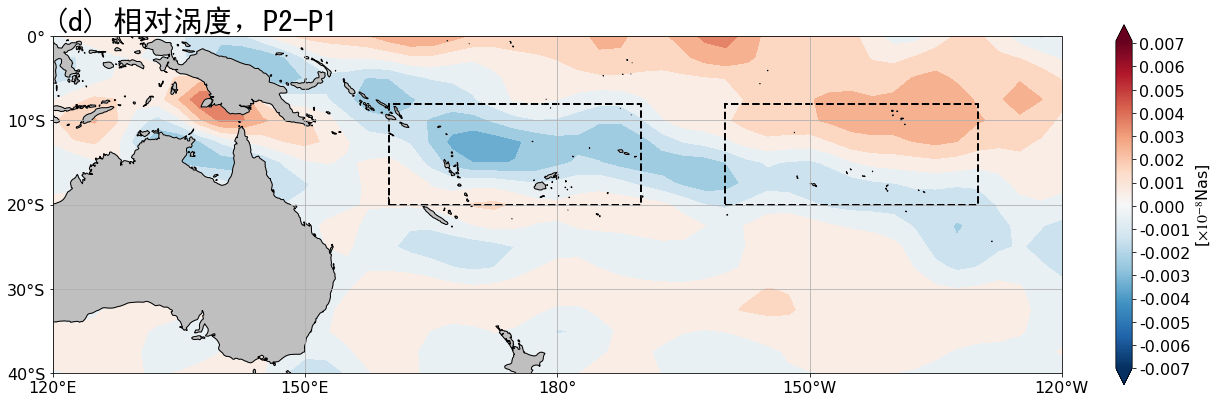

In [14]:
from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from matplotlib import rcParams
from matplotlib import patches
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

longitude, latitude = dataset_vwnd.variables['lon'],dataset_vwnd.variables['lat']


# 设置字体
config = {
    "font.family": 'Times New Roman',
    "font.size": 16,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 0.0071
MIN = -0.007 
INTER = 0.001
# 设置经纬度
lon = vlon[:].data
lat = vlat[19:56].data
# # 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
# print(diff_pacific_contre.max(), diff_pacific_contre.min())


fig = plt.figure(figsize=(15,5))


proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(d) 相对涡度，P2-P1',loc='left',
                  fontproperties='SimHei', 
                  fontsize =30, fontweight='bold')
# fig_ax1.contourf(lon, lat, diff, 
#                 levels=bins, 
# #                 color=['blue','red','yellow','black'],
# #                 hatches='///',
#                 transform=cartopy.crs.PlateCarree(),
#                cmap=plt.cm.RdBu_r)
cont = fig_ax1.contourf(lon, lat, diff, 
                 levels=np.arange(MIN, MAX, INTER),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
# fig_ax1.contourf(lon, lat, diff,levels=[0,0.05,1], zorder=1, hatches=['....',None],colors="none", transform=ccrs.PlateCarree())

# black_quarter = patches.Rectangle((146,-24),71,19,linestyle = 'dashed', 
#                                   lw=4, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
# fig_ax1.add_patch(black_quarter)

black_quarter_b1 = patches.Rectangle((160,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
black_quarter_b2 = patches.Rectangle((200,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
fig_ax1.add_patch(black_quarter_b1)
fig_ax1.add_patch(black_quarter_b2)

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

# cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-1.25,1.25,8))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::1])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',
                 ticks=np.arange(MIN, MAX, INTER).tolist(),                            label='[$\\times 10^{-8}$Nas]',                       
                 extend='both', 
#                  label='$\\times 10^{10}$',
                fraction=0.0155) 

# plt.colorbar(cont,fraction=0.012)

plt.savefig("rv_20240308_CN.png",dpi=300,bbox_inches='tight')
plt.show()